# Analysis of multi-omics data of chronic lymphocytic leukemia patients

In [22]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook shows a reanalyis using `SOFA` of multi-omics data of chronic lymphocytic leukemia patients. The data and original analysis was published in:    
Lu, J., Cannizzaro, E., Meier-Abt, F., Scheinost, S., Bruch, P.M., Giles, H.A., Lütge, A., Hüllein, J., Wagner, L., Giacopelli, B. and Nadeu, F., 2021. Multi-omics reveals clinically relevant proliferative drive associated with mTOR-MYC-OXPHOS activity in chronic lymphocytic leukemia. Nature cancer, 2(8), pp.853-864.

In [38]:

import sofa

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from muon import MuData
import warnings
warnings.filterwarnings('ignore')

rna = pd.read_csv("data/cll_data/rna_data.csv", index_col=0)
meth = pd.read_csv("data/cll_data/meth_data.csv", index_col=0)
drug = pd.read_csv("data/cll_data/drug_data.csv", index_col=0)
mutation = pd.read_csv("data/cll_data/mutation_data.csv", index_col=0)
cllpd =  pd.read_csv("data/cll_data/cllpd.csv", index_col=0)
survival = pd.read_csv("data/cll_data/survival_data.csv", index_col=0)
demographic = pd.read_csv("data/cll_data/demographic_data.csv", index_col=0)
doubling_time = pd.read_csv("data/cll_data/doublingTime_data.csv", index_col=0)


inter = np.intersect1d(np.intersect1d(np.intersect1d(rna.index, meth.index),drug.index),demographic.index)

scaler = StandardScaler()
rna = pd.DataFrame(scaler.fit_transform(rna), columns = rna.columns, index = rna.index)
meth = pd.DataFrame(scaler.fit_transform(meth), columns = meth.columns, index = meth.index)
drug = pd.DataFrame(scaler.fit_transform(drug), columns = drug.columns, index = drug.index)

llh = ["gaussian", "gaussian", "gaussian"]
views = ["mrna", "methylation", "drug"]

In [39]:
# get all observation ids that are in all datasets
all_obs = np.unique(np.concatenate((rna.index, meth.index, drug.index)))[np.unique(np.concatenate((rna.index, meth.index, drug.index)), return_counts=True)[1] >=2]
len(all_obs)

217

In [40]:
# align observations in all datasets and introduces nan for missing values
def align_df(df, idx):
    out = pd.DataFrame(np.nan, columns = df.columns, index=idx)
    idx = np.intersect1d(idx,df.index.tolist())
    df = df.loc[idx]
    out.loc[df.index,:] = df
    return out

rna = align_df(rna, all_obs)
drug = align_df(drug, all_obs)
meth = align_df(meth, all_obs)
survival = align_df(survival, all_obs)
mutation = align_df(mutation, all_obs)
demographic = align_df(demographic, all_obs)
doubling_time = align_df(doubling_time, all_obs)

# each view stored in data list
data = [rna, meth, drug]
# likelihood for each view
llh = ["gaussian", "gaussian", "gaussian"]

In [41]:
# generate input mudata object of omics views
adata = [sofa.tl.get_ad(data[i], llh[i]) for i in range(len(data))]
Xmdata = MuData({views[i]:adata[i] for i in range(len(adata))})
Xmdata

MuData object with n_obs × n_vars = 217 × 10315
  3 modalities
    mrna:	217 x 5000
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    methylation:	217 x 5000
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    drug:	217 x 315
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'

In [42]:
# generate input mudata object of target covariates
age_ad = sofa.tl.get_ad(demographic[["age"]], llh = "gaussian")
sex_ad = sofa.tl.get_ad(demographic[["sex"]], llh = "bernoulli")
trisomy_ad = sofa.tl.get_ad(mutation[["trisomy12"]], llh = "bernoulli")
ighv_ad = sofa.tl.get_ad(mutation[["IGHV"]], llh = "bernoulli")

Ymdata = MuData({"trisomy12":trisomy_ad, "IGHV": ighv_ad, "Age": age_ad, "Sex": sex_ad})
Ymdata

MuData object with n_obs × n_vars = 217 × 4
  4 modalities
    trisomy12:	217 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    IGHV:	217 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    Age:	217 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'
    Sex:	217 x 1
      uns:	'llh', 'scaling_factor'
      obsm:	'mask'

In [43]:
# collect sample metadata
metadata = np.hstack([trisomy_ad.X,ighv_ad.X, age_ad.X, sex_ad.X])
metadata = pd.DataFrame(metadata, columns=["trisomy12", "IGHV", "Age", "Sex"])

In [44]:
# generate design matrix with n_covariates x n_factors
n_factors = 7
design = torch.zeros((len(Ymdata.mod), n_factors))
design[0,0] = 1
design[1,1] = 1
design[2,2]=1
design[3,3]=1

design


tensor([[1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]])

The design matrix specifies which factor should be guided by which covariates. In our case the first 4 factors are each guided by the 4 entries in Ymdata (IGHV, trisomy12, Age, Sex).

In [45]:
model = sofa.SOFA(Xmdata=Xmdata,
            Ymdata = Ymdata,
            num_factors=7,
            design = design,
            device=torch.device('cpu'),
            horseshoe = True,
            metadata= metadata,
            subsample=0)



This sets up the model, key parameters are:

* Xmdata: contains the omics modalities as MuData object
* Ymdata: contains the target covariates as MuData object
* num_factors: number of factors to fit
* device: device to use for fitting. We highly recommend to run `SOFA` with a cuda device (torch.device("cuda"))
* horseshoe: whether to use sparse horseshoe priors on weights
* subsample: whether to subsample the data during fitting. Recommended for very large data sets like single cell data sets.



  0%|          | 0/3500 [00:00<?, ?it/s]

Current Elbo 3.16E+06 | Delta: -2628: 100%|██████████| 3500/3500 [13:44<00:00,  4.24it/s]   


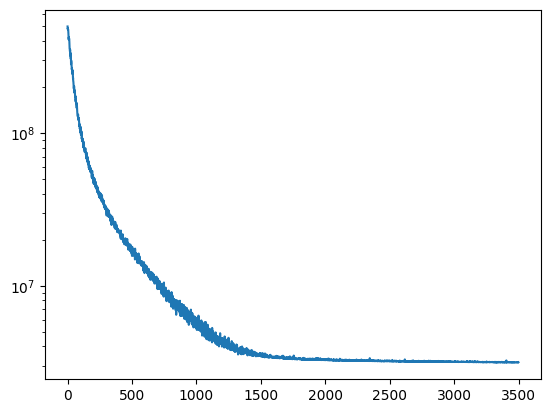

In [46]:
# fit and plot loss
model.fit(n_steps=3500, lr=0.01)
plt.semilogy(model.history)


<Axes: xlabel='Loadings', ylabel='Features'>

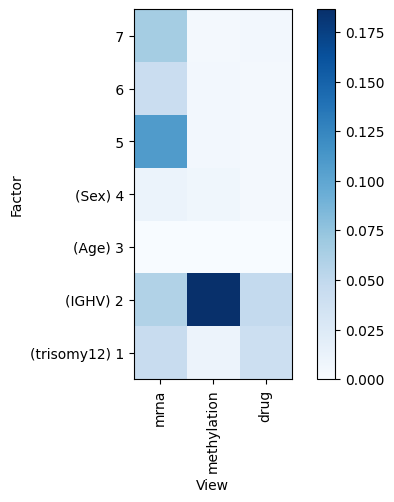

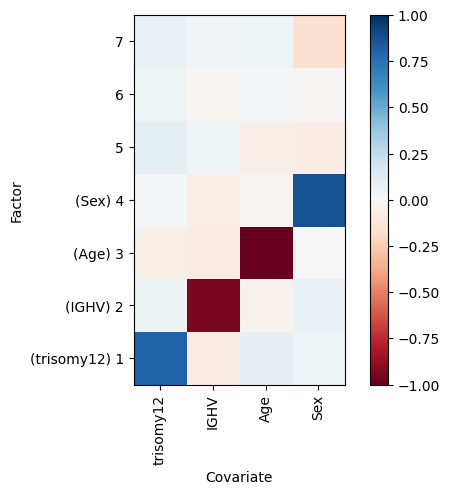

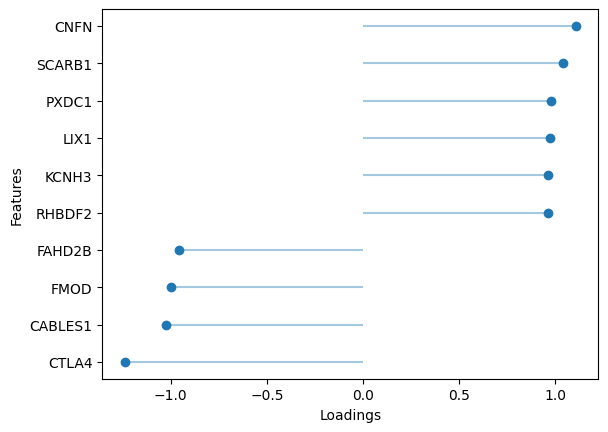

In [48]:
# plot fraction of variance explained of each view by each factor
sofa.pl.plot_variance_explained(model)

# plot factor covariate correlations
sofa.pl.plot_factor_covariate_cor(model, metavar=["trisomy12", "IGHV", "Age", "Sex"])

# plot top weights of factor 1 in view 1
sofa.pl.plot_top_loadings(model, view="mrna", factor=0)

In [49]:
# to access weights and factors directly use attributes Z and W:
Z = sofa.tl.get_Z(model)
W = sofa.tl.get_W(model, view="mrna")
